In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of a feature layer that have users and movies embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
*  **Movie id**: Idem to User id.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

In [2]:
import os

def show_env_var(varname):
    if varname in os.environ:
        print(f'{varname}: {os.environ[varname]}')
    else:
        print(f'{varname} undefined')

        
        
show_env_var('MODIN_OUT_OF_CORE')
show_env_var('MODIN_MEMORY')
show_env_var('MODIN_ON_RAY_PLASMA_DIR')

MODIN_OUT_OF_CORE: true
MODIN_MEMORY: 500000000
MODIN_ON_RAY_PLASMA_DIR: /home/adrian/tmp


import os

def show_env_var(varname):
    if varname in os.environ:
        print(f'{varname}: {os.environ[varname]}')
    else:
        print(f'{varname} undefined')

        
        
show_env_var('MODIN_OUT_OF_CORE')
show_env_var('MODIN_MEMORY')
show_env_var('MODIN_ON_RAY_PLASMA_DIR')### Required libraries

In [3]:
import sys
sys.path.append('./src')

import ray
import modin

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from callback import MetricsPlotter
from util import tf_detected_devices, tf_version, plot_model, dataframe_to_dataset, PCAPlotter, random_colors, random_color 
from recommendation import EmbeddingDenseModelFactory, Recommender, ModelHelper
from data import InMemoryXyDataGenerator, MovieLensDataSource, Dataset

import warnings
warnings.filterwarnings("ignore")

In [4]:
modin.__version__

'0.8.3'

In [5]:
ray.shutdown()

In [6]:
if not ray.is_initialized():
    ray.init(num_cpus=24, num_gpus=1, dashboard_host="0.0.0.0", dashboard_port=8080)
else:
    print('Ray is already active!')

2021-02-13 19:01:26,026	INFO services.py:1171 -- View the Ray dashboard at http://192.168.0.250:8080


### Config parameters

In [7]:
train_model = True

dataset_size = 'ml-latest' # 250MB
# dataset_size = 'ml-25m' # 25MB
# dataset_size = 'ml-latest-small' # 1MB

In [8]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

### Check environment

Show GPU model:

In [9]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce RTX 3080, 10010 MiB


Let's check tensorflow version:

In [13]:
tf_version()

'Tensorflow version: 2.5.0-dev20210209'

Let's check devices that tensorflow detect:

In [14]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,7G,"device: 0, name: GeForce RTX 3080, pci bus id:..."


In [15]:
tf.debugging.set_log_device_placement(False)

In [16]:
tf.test.is_built_with_cuda()

True

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Download dataset

Create a data source to download and read dataset files:

In [18]:
print('Dataset sizes:', MovieLensDataSource.sizes())

Dataset sizes: ['ml-latest-small', 'ml-25m', 'ml-latest']


Check: [Movie lens datasets](https://grouplens.org/datasets/movielens/)

In [19]:
ds = MovieLensDataSource(size = dataset_size)

In [20]:
dataset = ds.dataset()

Available files:

In [21]:
print(ds.files())

['ratings.csv', 'tags.csv', 'links.csv', 'movies.csv', 'genome-tags.csv', 'genome-scores.csv']


Rating that users give to each movie:

In [22]:
dataset.ratings().head()

,userId,movieId,rating,timestamp,user,movie
0,1,307,3.5,1256677221,0,304
1,1,481,3.5,1256677456,0,477
2,1,1091,1.5,1256677471,0,1069
3,1,1257,4.5,1256677460,0,1229
4,1,1449,4.5,1256677264,0,1414


In [23]:
dataset.ratings().isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
user         0
movie        0
dtype: int64

Movie catalog: Each movie has a tittle and a list of genres.

In [24]:
dataset.movies().head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Tags that users put to movies: Each line of this file after the header row represents one tag applied to one movie by one user.

In [25]:
dataset.tags().head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


**Links** file contains one row by movie and eack column represent the movie id for each movie site:

* **movieId**: is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

* **imdbId**: is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

* **tmdbId**: is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>

**Note**: It will we usefull when we test each model.

In [26]:
dataset.links().head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Analize and prepare the required data

First, get 15 users with highest total ratings sum: 

In [27]:
dataset.highest_user_ratings(limit=15).head()

,rating
userId,
123100,23715
117490,9279
134596,8381
212343,7884
242683,7515


Get 15 moviles with highest total ratings sum:

In [28]:
dataset.highest_movie_ratings(limit=15).head()

,rating
movieId,
318,97999
356,97040
296,92406
593,87899
2571,84545


Show users vs. movies ratings: It can appresciated that some user did not give a rating to some movies (NaN).

In [29]:
dataset.top_user_vs_movies(limit=15)

movieId,1,110,260,296,318,356,480,527,589,593,1196,1198,1210,2571,2959
userId,,,,,,,,,,,,,,,
48470,4.5,4.5,4.0,5.0,4.5,4.0,4.0,4.5,5.0,3.5,4.0,3.0,3.5,3.5,3.5
63783,5.0,1.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0
77609,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,2.5,4.0,3.0,4.0,2.0
94843,1.0,2.5,2.5,3.5,2.5,3.0,1.0,0.5,NaN,3.0,2.5,2.5,1.0,3.0,2.5
111908,5.0,3.5,5.0,5.0,5.0,2.0,3.0,5.0,4.0,2.0,5.0,5.0,3.5,5.0,4.0
117490,4.0,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
123100,4.0,3.5,4.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0,4.0,4.0,4.0,4.0,3.5
134596,3.0,4.0,4.0,4.0,4.5,3.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0,4.5,4.0
141955,2.5,2.5,3.5,3.0,1.0,1.0,2.0,NaN,3.0,3.0,3.5,3.0,3.0,2.5,1.5


Users and movies count:

In [30]:
n_users, n_movies = dataset.n_users(), dataset.n_movies()
n_users, n_movies

(283228, 53889)

Min and max rating:

In [31]:
min_rating, max_rating = dataset.min_rating(), dataset.max_rating()
min_rating, max_rating

(0.5, 5.0)

Build X and y sets (Equivalent to features and label for ech training test).

In [32]:
X = dataset.ratings()[['user', 'movie']].values
y = dataset.ratings()['rating'].values

Show features an label for first sample:

In [33]:
X[0], y[0]

(array([  0, 304]), 3.5)

Split data to train, validation and test sets:

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01) # , random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((27475909, 2), (27475909,), (277535, 2), (277535,))

### Deep Model: User and Movie embeddings + Dense layers 

Define train and validation batch size: 

In [35]:
import math

if dataset_size == 'ml-latest':
    steps  = 100
    epochs = 2
elif dataset_size == 'ml-25m':
    steps  = 20
    epochs = 20
else:
    steps  = 200
    epochs = 20

batch_size        = math.floor(X_train.shape[0] / steps)
val_batch_size    = math.floor(X_val.shape[0] / steps)
plot_interval     = math.floor(steps / 8)
evaluate_interval = plot_interval + 1

print('Epochs               :', epochs)
print('Steps                :', steps)
print('Train Batch Size     :', batch_size)
print('Validation Batch Size:', val_batch_size)
print('Plot Interval        :', plot_interval)
print('Evaluate Interval    :', evaluate_interval)

Epochs               : 2
Steps                : 100
Train Batch Size     : 274759
Validation Batch Size: 2775
Plot Interval        : 12
Evaluate Interval    : 13


Define data generators. This are used in the model train process(fit) to generate a samples batch.

In [36]:
def to_input(X, y): return [X[:, 0], X[:, 1]], y

training_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    batch_size, 
    shuffle=True, 
    to_input=to_input
)

validation_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val,
    val_batch_size,
    shuffle=True,
    to_input=to_input
)

Create the model:

In [37]:
model = EmbeddingDenseModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=70,
    min_rating=min_rating, 
    max_rating=max_rating,
    units=[512, 512, 100],
    dropout=[0.5, 0.5, 0.5]
)

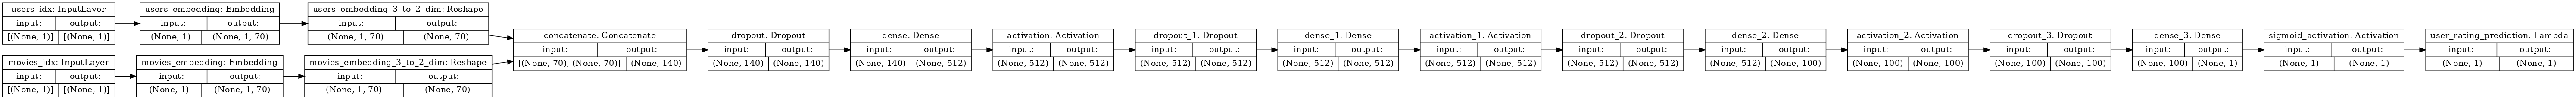

In [38]:
plot_model(model)

In [39]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 70)        19825960    users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 70)        3772230     movies_idx[0][0]                 
____________________________________________________

Train model:

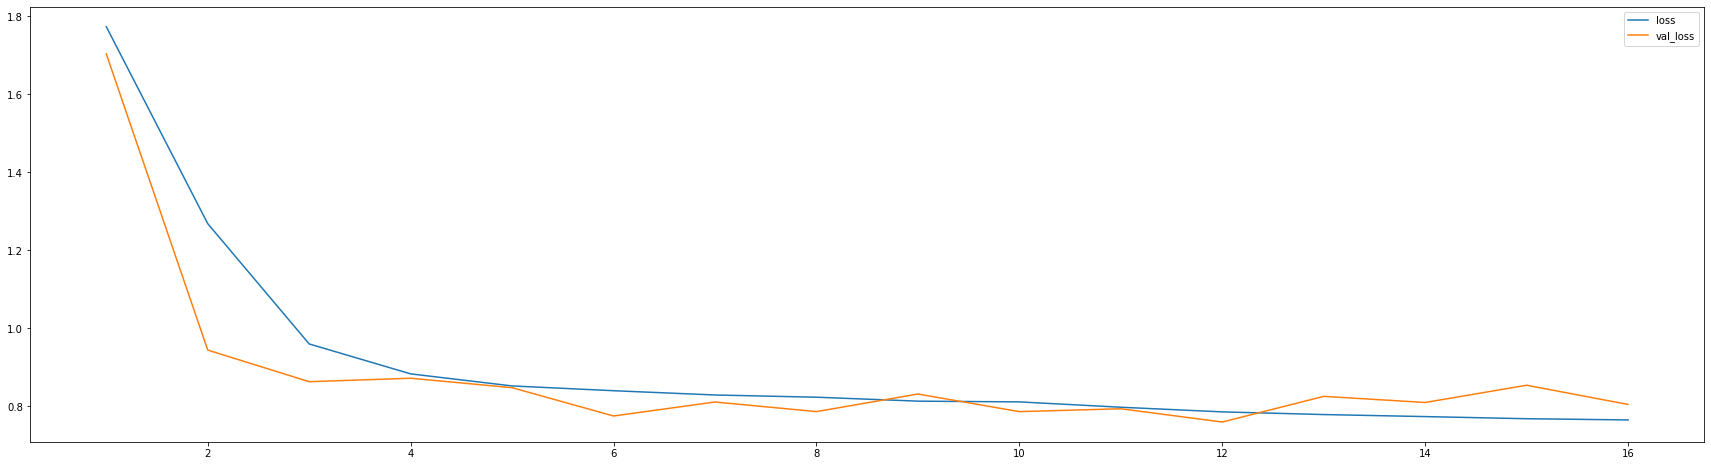

100/100 [==============================] - 93s 918ms/step - loss: 0.7829 - val_loss: 0.7818


In [40]:
if train_model:
    history = model.fit_generator(
        generator=training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1, 
        callbacks=[
            MetricsPlotter(
                validation_generator=validation_generator, 
                metrics_names=['loss'],
                plot_interval=plot_interval,
                evaluate_interval=evaluate_interval,
                batch_size=batch_size,
                val_batch_size=val_batch_size
            )
        ]
    )

Save the weights tthat model has learned:

In [41]:
WEIGHTS_PATH = f'./weights/deep_model_weights_{dataset_size}.h5'

model.save_weights(WEIGHTS_PATH) if train_model else model.load_weights(WEIGHTS_PATH)

Check model loss after training process:

In [42]:
def evaluate_xy_model(model, X, y, batch_size):
    data_generator = InMemoryXyDataGenerator(X, y, len(y), to_input=to_input)    
    X_t, y_t = data_generator[0]
    return model.evaluate(X_t, y_t, batch_size=batch_size, verbose=0)

In [43]:
evaluate_xy_model(model, X_val, y_val, batch_size)

0.7871204614639282

## Check rating prediction

In [44]:
import random

class UserMovieIdxPairGenerator:
    def __init__(self, train_input, dataset):
        self.__train_input = pd.DataFrame(train_input, columns=['user', 'movie'])
        self.__dataset = dataset

    def rand_user_idx(self): return random.choice(self.__train_input['user'])
 
    def rand_movie_idx(self): return random.choice(self.__train_input['movie'])
 
    def generate(self, has_rating=True):
        finish = True
        user_idx, movie_idx = None, None
        while finish:
            user_idx, movie_idx = self.rand_user_idx(), self.rand_movie_idx()
            pair = self.__dataset.rating_of(user_idx, movie_idx)
            finish = pair.empty if has_rating else not pair.empty
        return user_idx, movie_idx

In [45]:
pair_generator = UserMovieIdxPairGenerator(X, dataset)

In [46]:
user_idx, movie_idx = pair_generator.generate(has_rating=True)
dataset.rating_of(user_idx, movie_idx)

,user,movie,userId,movieId,rating,title,genres
0,184821,11728,184822,51662,1.5,300 (2007),Action|Fantasy|War|IMAX


In [47]:
user_idx, movie_idx = pair_generator.generate(has_rating=False)
dataset.rating_of(user_idx, movie_idx)

,user,movie,userId,movieId,rating,title,genres


Predict a non-existent rating:

In [48]:
user_idx, movie_idx = pair_generator.generate(has_rating=False)
ModelHelper(model).predict_rating(user_idx=104, movie_idx=0)

,movie,predicted_rating
0,0,3.987403


In [49]:
 dataset.rating_of(user_idx, movie_idx)

,user,movie,userId,movieId,rating,title,genres


Predict ratings used to train model:

In [50]:
def rand_compare_train_rating():
    user_idx, movie_idx = pair_generator.generate()
    movie_ratting = dataset.rating_of(user_idx, movie_idx)
    predicted_movie_ratting = ModelHelper(model).predict_rating(user_idx, movie_idx)
    result = pd.merge(movie_ratting, predicted_movie_ratting, how='left', on='movie')
    return result[['user', 'movie', 'title', 'predicted_rating', 'rating']]

In [51]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,268567,1596,Gattaca (1997),3.238073,1.0


In [52]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,230182,4212,Shrek (2001),3.340176,3.0


In [53]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,56085,587,"Silence of the Lambs, The (1991)",4.641591,5.0


In [54]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,214934,3421,Frequency (2000),2.506769,2.5


In [55]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,81709,0,Toy Story (1995),3.365312,1.5


In [56]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,150589,4212,Shrek (2001),2.971971,3.5


### Check recommendations

In [57]:
recommender = Recommender(model, dataset)

#### Top movies for a user

In [58]:
def rand_compare_top_movies(limit=10):
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    return recommender.top_movies_by_user_id(user_id, limit=limit)

In [59]:
rand_compare_top_movies()

User Id: 29373



,predicted_rating,title,movieId,movie
8461,4.469819,Planet Earth II (2016),171011,44496
2560,4.434796,Planet Earth (2006),159817,40073
8462,4.389050,Cosmos,171495,44709
110,4.388126,"Shawshank Redemption, The (1994)",318,315
7533,4.383275,Band of Brothers (2001),170705,44359
8464,4.375538,The Godfather Trilogy: 1972-1990 (1992),172591,45237
26118,4.373518,The Reichenbach Fall (2012),191999,53156
23288,4.340988,Elway To Marino (2013),139108,32434
8440,4.323177,Harakiri (Seppuku) (1962),26082,8597
11119,4.308397,"Century of the Self, The (2002)",105250,21924


#### Similar movies

In [60]:
def rand_similar_movies(title=None, limit=10):
    print(f'Movie\n')
    
    if title:
        movie = dataset.movies_by_title(title)[:1]
        movie_id = movie['movieId'].item()
        display(movie)
    else:
        movie_id = random.choice(dataset.movie_ids())
        display(dataset.movie_by_id(movie_id))

    print(f'Similars (UNORDERED!!!)')
    return recommender.movies_similar_to(movie_id, limit=limit)

In [61]:
recommended_movies = rand_similar_movies(title='Toy Story', limit=20)
recommended_movies

Movie



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Similars (UNORDERED!!!)


,movieId,movie,title,genres
0,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
68469,1204,1179,Lawrence of Arabia (1962),Adventure|Drama|War
83884,25742,8343,Destiny (a.k.a. Between Two Worlds) (Der müde ...,Fantasy
83924,26614,8957,"Bourne Identity, The (1988)",Action|Adventure|Drama|Mystery|Thriller
88147,33154,10068,Enron: The Smartest Guys in the Room (2005),Documentary
89761,73145,14673,Under the Bridges (Unter den Brücken) (1945),Comedy|Drama|Romance
89765,87327,17379,Camp de Thiaroye (1989),Drama|War
89774,88203,17592,Car Bonus (Autobonus) (2001),Documentary
89782,91529,18397,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX
109493,94727,19116,Border Radio (1987),Drama


In [62]:
similar_movie_ids = recommended_movies['movieId'].unique()

In [63]:
import textwrap

simiar_movie_titles = recommended_movies['title'].unique()
r = dataset.ratings().groupby('movieId')['movieId', 'rating'].mean()

similar_movie_ratings = [r[r['movieId'] ==  i]['rating'].item() for i in similar_movie_ids]
simiar_movie_titles = [f'  {r:1.3f} - {textwrap.shorten(t, width=20)}' for t, r in zip(simiar_movie_titles, similar_movie_ratings)]

In [64]:
movie_embeddings = ModelHelper(model).movie_embeddings_matrix

movie_title = recommended_movies['title'][:1].item()
similar_movie_labels = {title:[idx] for idx, title in enumerate(simiar_movie_titles)}
similar_movie_indexes = recommended_movies['movie'].unique()
similar_movie_embeddings = np.take(movie_embeddings, axis=0, indices=similar_movie_indexes)

pca = PCA(n_components=2)
similar_movie_pca = pca.fit_transform(similar_movie_embeddings)

In [65]:
comp_var = [f'{cv * 100:.0f}%' for cv in pca.explained_variance_ratio_]
tot_variance = f'{sum(pca.explained_variance_ratio_) * 100:.0f}%'

print(f'Variance by dimnesion: {comp_var}')
print(f'Variance: {tot_variance}')

Variance by dimnesion: ['17%', '12%']
Variance: 30%


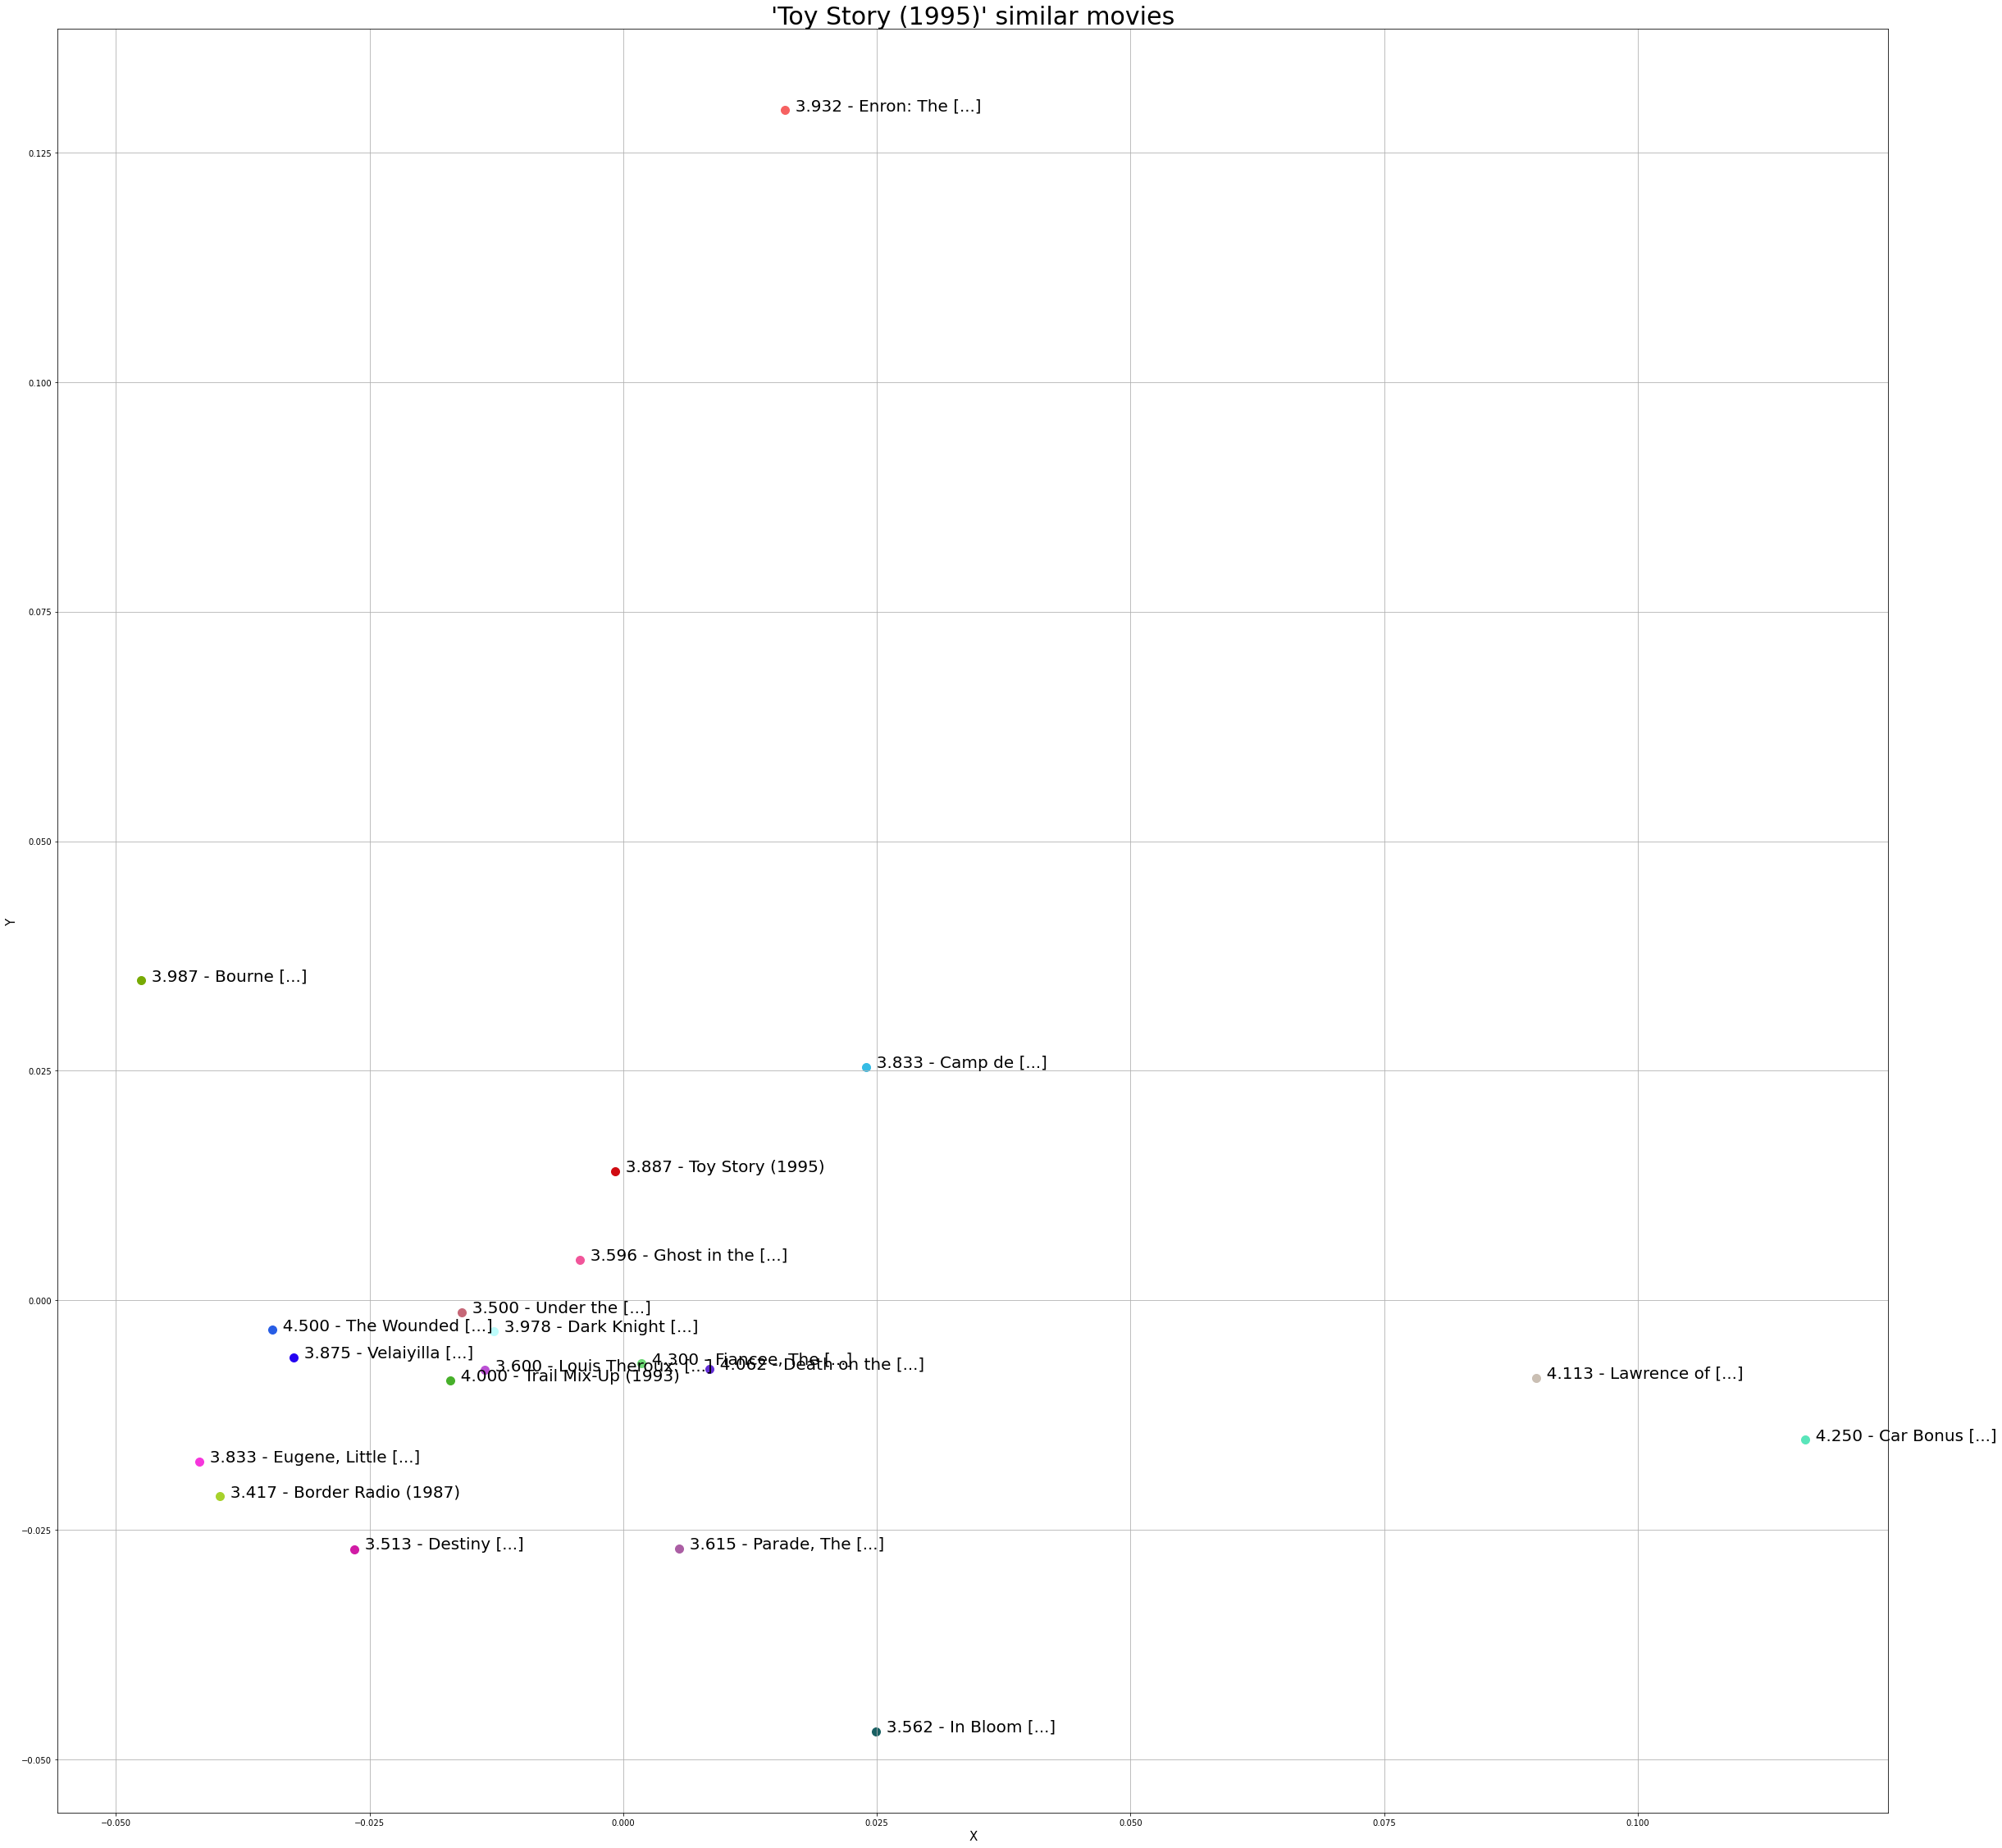

In [66]:
PCAPlotter() \
    .data(similar_movie_pca) \
    .canvas(size=(40, 40)) \
    .labels(similar_movie_labels) \
    .title(f'\'{movie_title}\' similar movies', font_size = 30) \
    .annotations(font_size=20) \
    .point(radius=100, color_distance=.2) \
    .plot()

#### Similar users

In [67]:
def rand_similar_users():
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    print(f'Similars (Unordered): {recommender.users_similar_to(user_id, limit=10)}')

In [68]:
rand_similar_users()

User Id: 204936

Similars (Unordered): [204936, 85008, 30624, 260589, 21820, 132425, 113813, 217024, 253443, 137738]


### Plot user and movie embedings

In [69]:
movie_embeddings = ModelHelper(model).movie_embeddings_matrix
user_embeddings = ModelHelper(model).user_embeddings_matrix

movies_pca = PCA(n_components=3).fit_transform(movie_embeddings)
users_pca = PCA(n_components=3).fit_transform(user_embeddings)

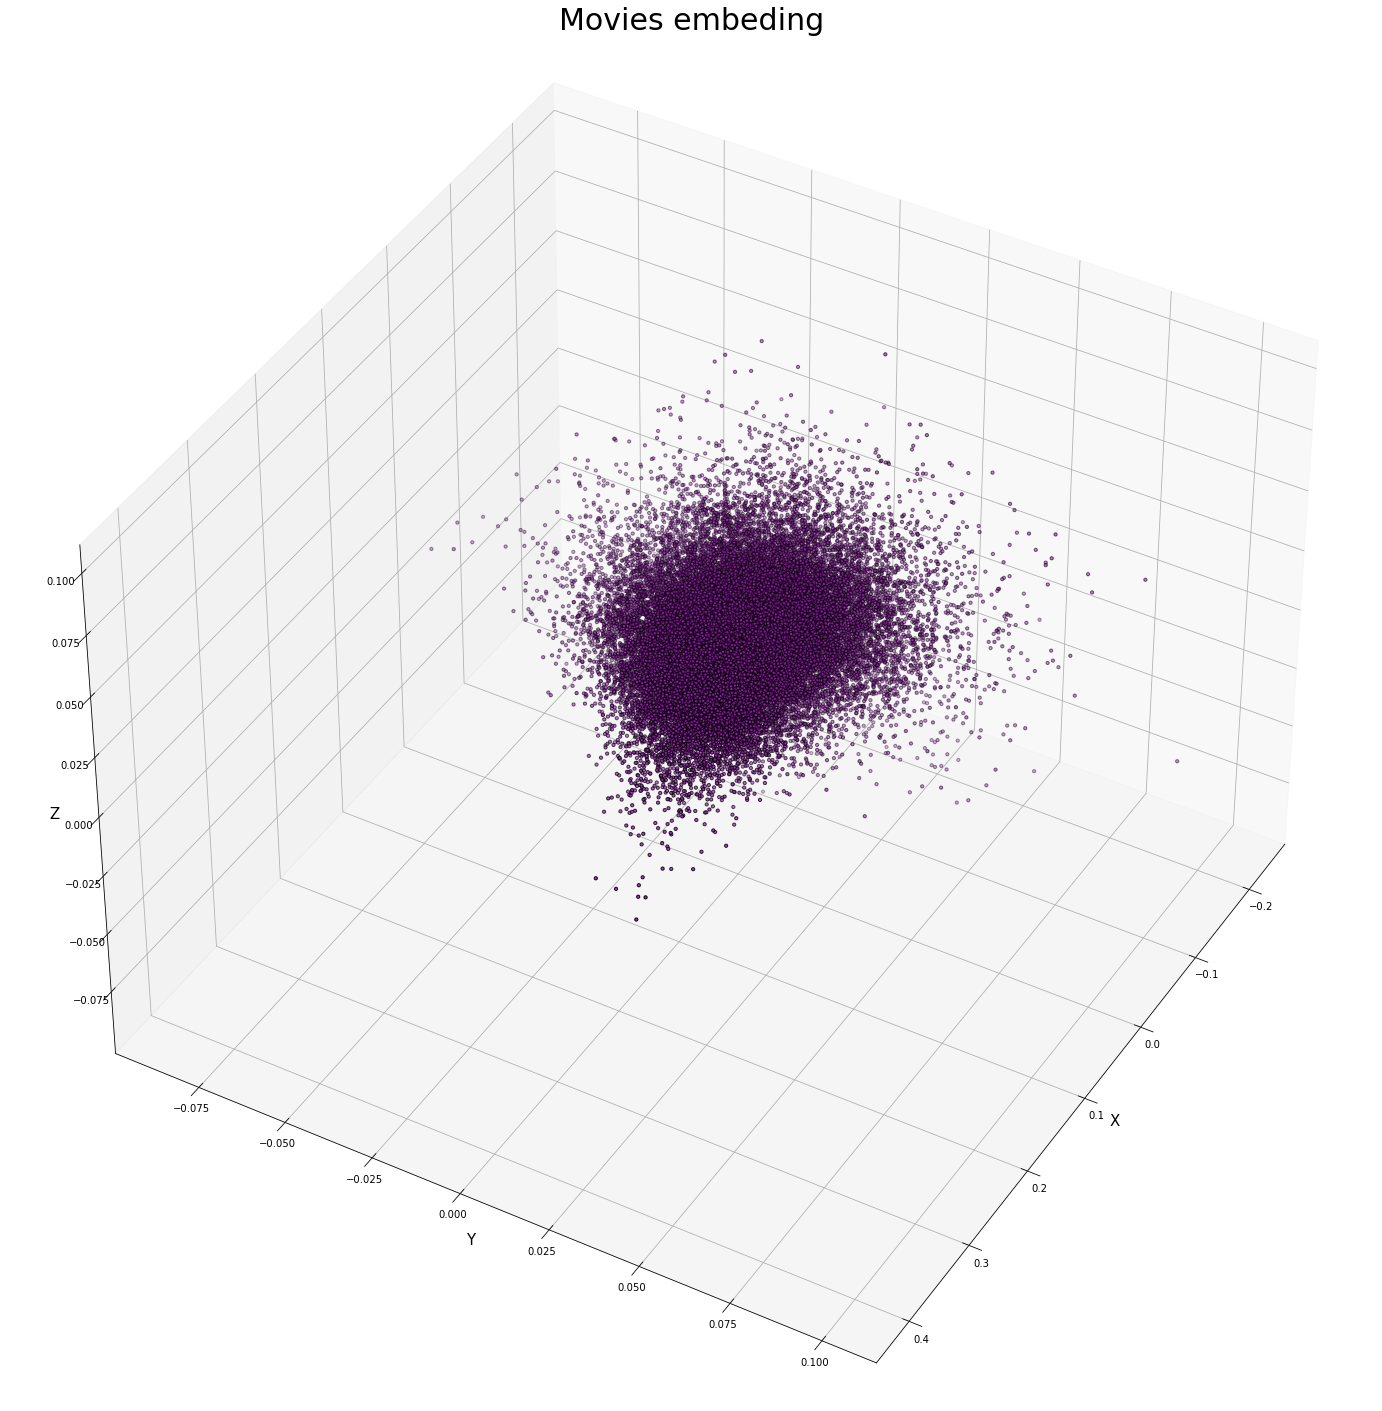

In [70]:
PCAPlotter() \
    .data(movies_pca) \
    .canvas(size=(20, 20), elevation=40, azimuthal_angle=30) \
    .title('Movies embeding', font_size = 30) \
    .point(radius=10) \
    .plot()

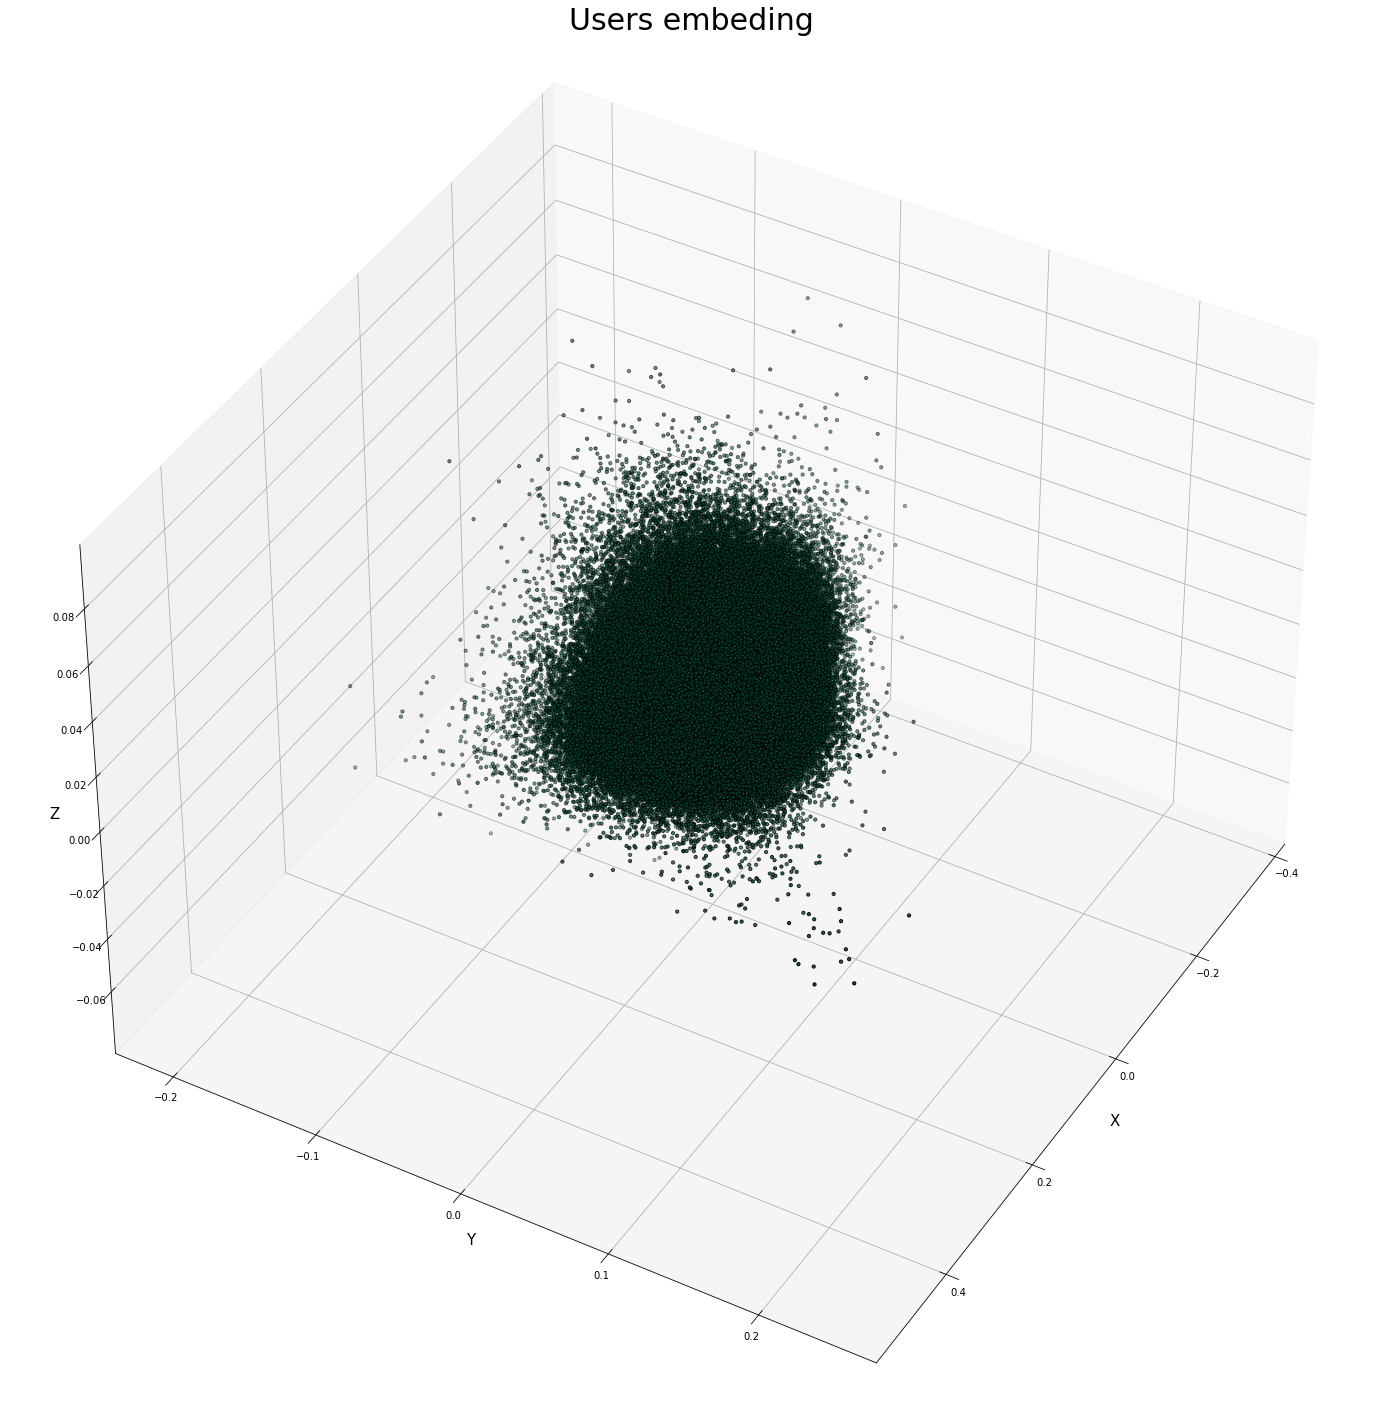

In [71]:
PCAPlotter() \
    .data(users_pca) \
    .canvas(size=(20, 20), elevation=40, azimuthal_angle=30) \
    .title('Users embeding', font_size = 30) \
    .point(radius=10) \
    .plot()

In [72]:
ratings = dataset.ratings()
movies = dataset.movies()

In [73]:
import pandas as pd

features = pd.merge(ratings, movies, how='left', on='movieId')
features = features[['userId', 'movieId', 'user', 'movie', 'genres']]

features['genres'] = features['genres']

features.head()

,userId,movieId,user,movie,genres
0,1,307,0,304,Drama
1,1,481,0,477,Drama|Thriller
2,1,1091,0,1069,Comedy
3,1,1257,0,1229,Comedy|Romance
4,1,1449,0,1414,Comedy
